In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import random
dataset = pd.read_csv('churn_data.csv') # Users who were 60 days enrolled, churn in the next 30



# EDA


In [ ]:
dataset.head(5) # Viewing the Data
dataset.columns
dataset.describe() # Distribution of Numerical Variables


,user,churn,age,credit_score,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,cc_disliked,cc_liked,cc_application_begin,app_downloaded,web_user,app_web_user,ios_user,android_user,registered_phones,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,left_for_two_month_plus,left_for_one_month,rewards_earned,reward_rate,is_referred
count,27000.000000,27000.000000,26996.000000,18969.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,23773.000000,27000.000000,27000.000000
mean,35422.702519,0.413852,32.219921,542.944225,3.341556,0.307000,28.062519,3.273481,0.073778,92.625778,0.050630,0.013111,8.197852,0.952481,0.606074,0.561741,0.393926,0.587259,0.420926,0.001296,0.018815,0.018185,0.004889,0.173444,0.018074,29.110125,0.907684,0.318037
std,20321.006678,0.492532,9.964838,61.059315,9.131406,1.055416,42.219686,8.953077,0.437299,88.869343,0.871366,0.238158,12.497243,0.212749,0.488628,0.496183,0.488628,0.492336,0.912831,0.035981,0.135873,0.133623,0.069751,0.378638,0.133222,21.973478,0.752016,0.465723
min,1.000000,0.000000,17.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,17810.500000,0.000000,25.000000,507.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.200000,0.000000
50%,35749.000000,0.000000,30.000000,542.000000,0.000000,0.000000,9.000000,0.000000,0.000000,65.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.780000,0.000000
75%,53244.250000,1.000000,37.000000,578.000000,1.000000,0.000000,43.000000,1.000000,0.000000,164.000000,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,1.530000,1.000000
max,69658.000000,1.000000,91.000000,838.000000,65.000000,29.000000,1067.000000,63.000000,29.000000,522.000000,65.000000,27.000000,263.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,114.000000,4.000000,1.000000


In [ ]:
# Cleaning Data
dataset[dataset.credit_score < 300]
dataset = dataset[dataset.credit_score >= 300]


In [ ]:
# Removing NaN
dataset.isna().any()
dataset.isna().sum()
dataset = dataset.drop(columns = ['credit_score', 'rewards_earned'])



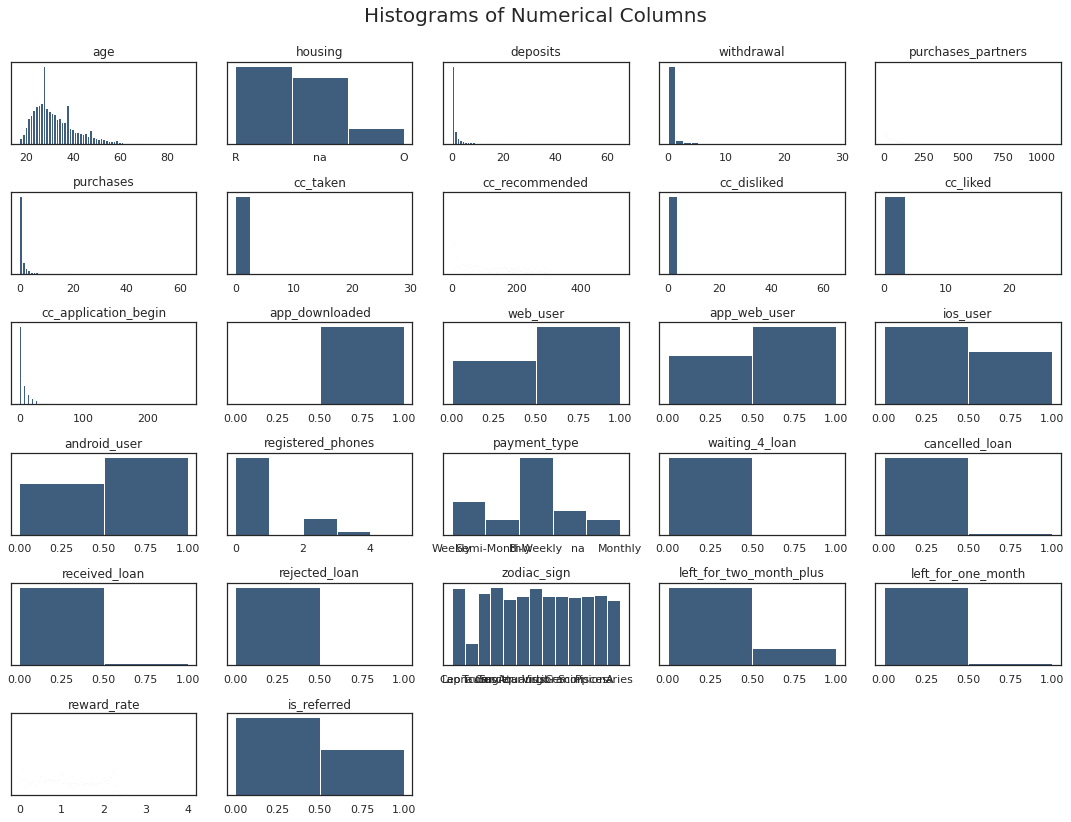

In [ ]:
## Histograms
dataset2 = dataset.drop(columns = ['user', 'churn'])
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(6, 5, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique())
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

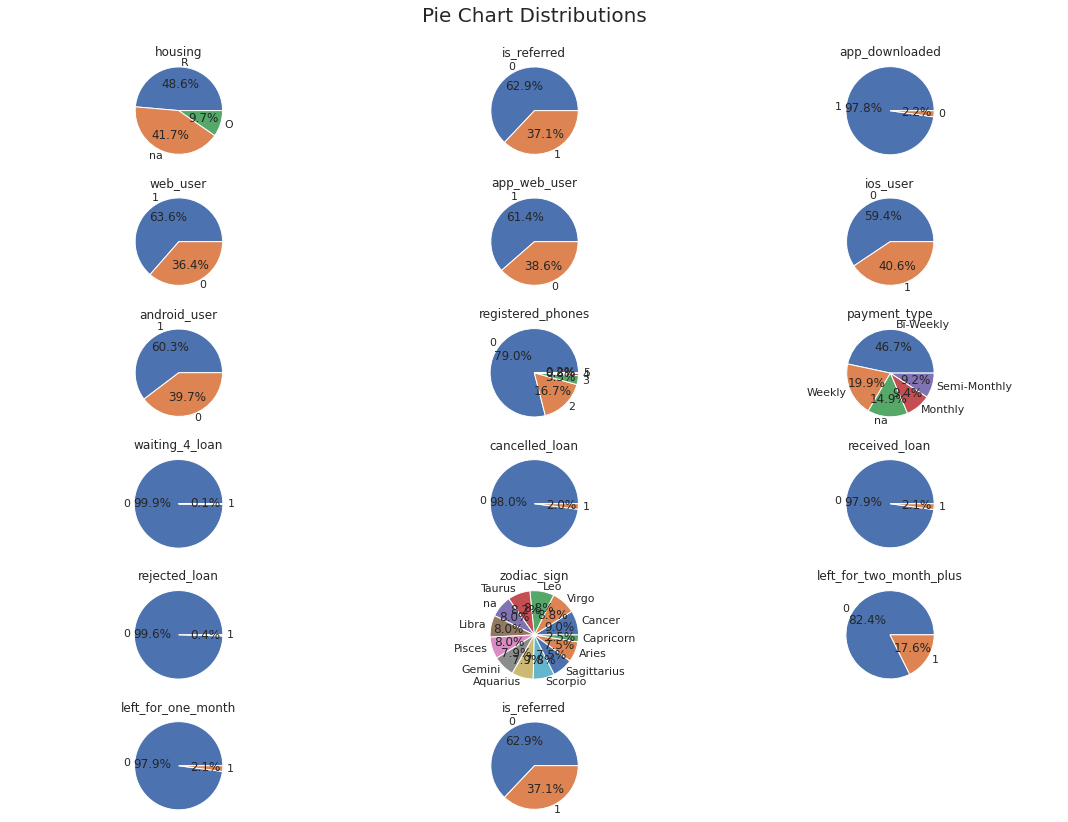

In [ ]:
## Pie Plots
dataset2 = dataset[['housing', 'is_referred', 'app_downloaded',
                    'web_user', 'app_web_user', 'ios_user',
                    'android_user', 'registered_phones', 'payment_type',
                    'waiting_4_loan', 'cancelled_loan',
                    'received_loan', 'rejected_loan', 'zodiac_sign',
                    'left_for_two_month_plus', 'left_for_one_month', 'is_referred']]
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Pie Chart Distributions', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(6, 3, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])
   
    values = dataset2.iloc[:, i - 1].value_counts(normalize = True).values
    index = dataset2.iloc[:, i - 1].value_counts(normalize = True).index
    plt.pie(values, labels = index, autopct='%1.1f%%')
    plt.axis('equal')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])




In [ ]:
## Exploring Uneven Features
dataset[dataset2.waiting_4_loan == 1].churn.value_counts()
dataset[dataset2.cancelled_loan == 1].churn.value_counts()
dataset[dataset2.received_loan == 1].churn.value_counts()
dataset[dataset2.rejected_loan == 1].churn.value_counts()
dataset[dataset2.left_for_one_month == 1].churn.value_counts()




1    207
0    184
Name: churn, dtype: int64

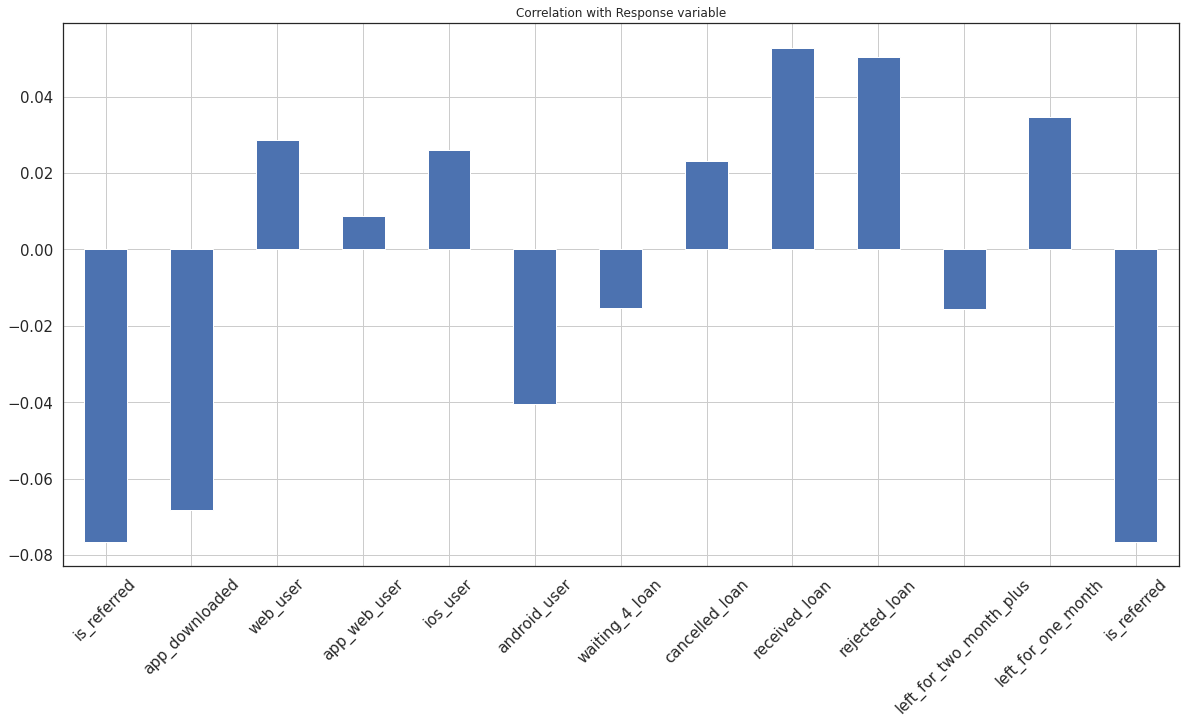

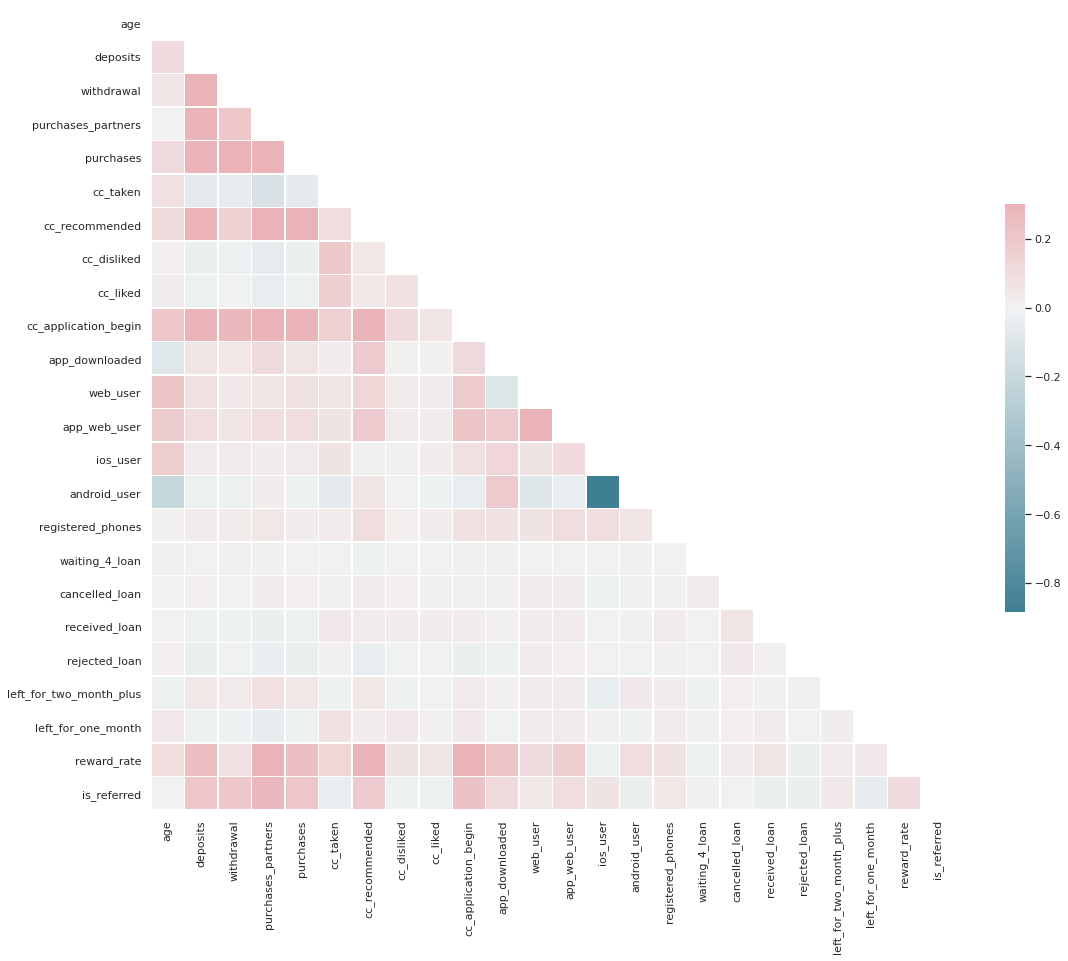

In [ ]:
## Correlation with Response Variable
dataset2.drop(columns = ['housing', 'payment_type',
                         'registered_phones', 'zodiac_sign']
    ).corrwith(dataset.churn).plot.bar(figsize=(20,10),
              title = 'Correlation with Response variable',
              fontsize = 15, rot = 45,
              grid = True)


## Correlation Matrix
sn.set(style="white")

# Compute the correlation matrix
corr = dataset.drop(columns = ['user', 'churn']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [ ]:
# Removing Correlated Fields
dataset = dataset.drop(columns = ['app_web_user'])

## Note: Although there are somewhat correlated fields, they are not colinear
## These feature are not functions of each other, so they won't break the model
## But these feature won't help much either. Feature Selection should remove them.

dataset.to_csv('new_churn_data.csv', index = False)


In [ ]:
dataset = pd.read_csv('new_churn_data.csv')


## Data Preparation
user_identifier = dataset['user']
dataset = dataset.drop(columns = ['user'])


In [ ]:
# One-Hot Encoding
dataset.housing.value_counts()
dataset.groupby('housing')['churn'].nunique().reset_index()
dataset = pd.get_dummies(dataset)
dataset.columns
dataset = dataset.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = 'churn'), dataset['churn'],
                                                    test_size = 0.2,
                                                    random_state = 0)


In [ ]:
# Balancing the Training Set
y_train.value_counts()

pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index

random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))

X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2


In [ ]:
#### Model Building ####


# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)


Test Data Accuracy: 0.6391


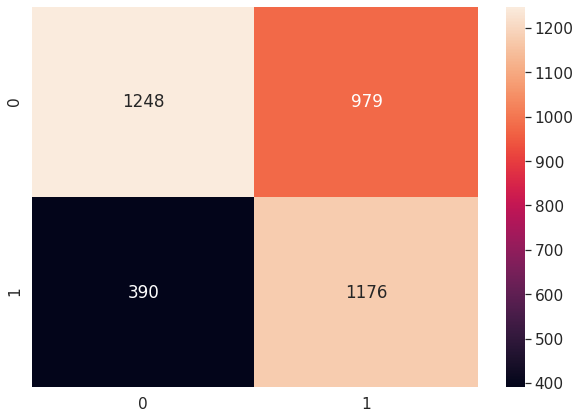

In [ ]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [ ]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

# Analyzing Coefficients
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)


SVM Accuracy: 0.659 (+/- 0.023)


,features,coef
0,age,-0.200802
1,deposits,0.066669
2,withdrawal,0.030112
3,purchases_partners,-0.800836
4,purchases,-0.194801
5,cc_taken,0.020702
6,cc_recommended,0.036270
7,cc_disliked,0.023994
8,cc_liked,-0.014358
9,cc_application_begin,0.057299


In [ ]:
#### Feature Selection ####


## Feature Selection
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Model to Test
classifier = LogisticRegression()
# Select Best X Features
rfe = RFE(classifier, 20)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]


[ True  True False  True  True False  True False False  True False  True
 False  True  True False  True  True  True False  True  True  True  True
 False  True  True  True False False False False False False False False
  True False False False False]
[ 1  1  8  1  1 14  1  9 16  1  2  1  3  1  1 12  1  1  1  7  1  1  1  1
  6  1  1  1 17  5 13 10  4 20 15 19  1 21 22 18 11]


Index(['age', 'deposits', 'purchases_partners', 'purchases', 'cc_recommended',
       'cc_application_begin', 'web_user', 'android_user', 'registered_phones',
       'cancelled_loan', 'received_loan', 'rejected_loan',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'payment_type_Bi-Weekly', 'payment_type_Monthly',
       'payment_type_Semi-Monthly', 'zodiac_sign_Pisces'],
      dtype='object')

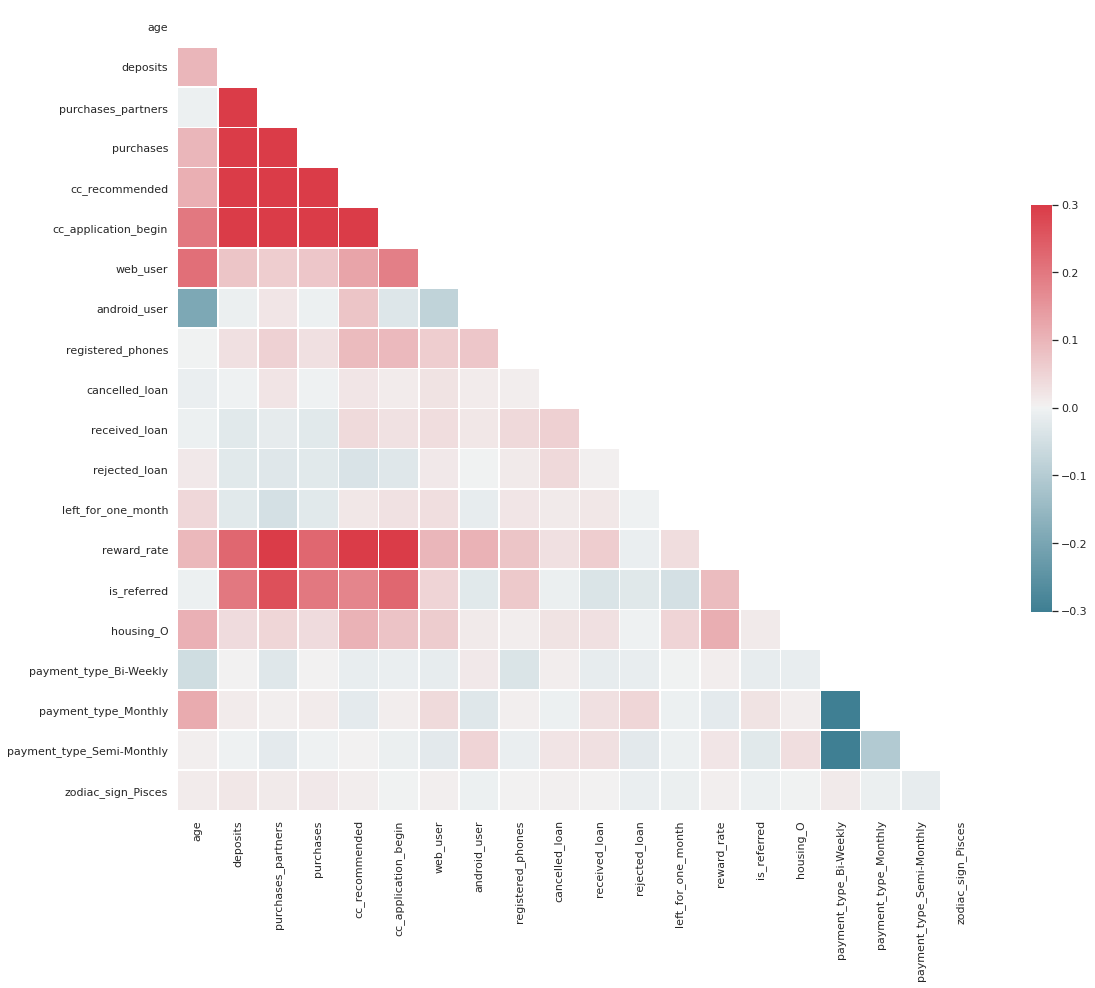

In [ ]:
# New Correlation Matrix
sn.set(style="white")

# Compute the correlation matrix
corr = X_train[X_train.columns[rfe.support_]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})    


Test Data Accuracy: 0.6383
SVM Accuracy: 0.658 (+/- 0.025)


,features,coef
0,age,-0.201197
1,deposits,0.060637
2,purchases_partners,-0.805560
3,purchases,-0.174627
4,cc_recommended,0.043270
5,cc_application_begin,0.068874
6,web_user,0.141614
7,android_user,-0.085771
8,registered_phones,0.120481
9,cancelled_loan,0.050539


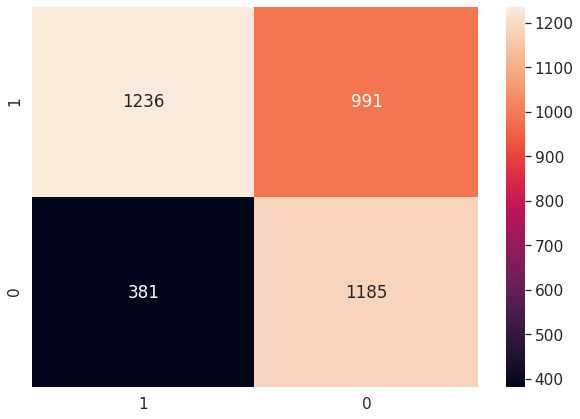

In [ ]:
# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = (1, 0), columns = (1, 0))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,
                             X = X_train[X_train.columns[rfe.support_]],
                             y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

# Analyzing Coefficients
pd.concat([pd.DataFrame(X_train[X_train.columns[rfe.support_]].columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)


#### End of Model ####

In [ ]:
# Formatting Final Results
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()
final_results['predicted_churn'] = y_pred
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)

